In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import style 
import seaborn as sns
style.use('default')

In [7]:
import sys
sys_path = sys.path.copy()
sys.path.append('../')
import utils
sys.path = sys_path

Table of contents:
* [Correlation](#Correlation)
* [Desciptives for Data](#Desciptives-for-Data)

## Read Data

In [8]:
# the news articles
articles = utils.load_articles(data_root_folder="../data/")

# dev and train data
data_train, data_dev = utils.load_data(data_root_folder="../data/")

# sentencized automatic emotion tags
sent_emotion_train, sent_emotion_dev = utils.load_articles(data_root_folder="../data/")

# Show Data
Dev data does not have the features *empathy_bin* and *distress_bin*, therefore we can exclude them.

In [9]:
print(data_train.shape)
data_train[:3]

(1860, 23)


,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay,emotion,gender,...,income,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...,sadness,1,...,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...,sadness,1,...,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab...",neutral,1,...,50000,6.0,5.0,5.0,5.5,5.5,3.571,2.0,3.429,4.0


In [10]:
print(data_dev.shape)
data_dev[:3]

(270, 21)


,message_id,response_id,article_id,essay,gender,education,race,age,income,empathy,...,emotion,personality_conscientiousness,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern
0,R_3QLVVnAgRBRH41U_1,R_3QLVVnAgRBRH41U,13,The story about the air strikes is very sadden...,1.0,4.0,3.0,20.0,24000.0,7.000,...,sadness,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143
1,R_3QLVVnAgRBRH41U_2,R_3QLVVnAgRBRH41U,127,It is clear that climate change is something t...,1.0,4.0,3.0,20.0,24000.0,3.167,...,sadness,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143
2,R_3QLVVnAgRBRH41U_3,R_3QLVVnAgRBRH41U,188,I did not know this comedian but thinking abou...,1.0,4.0,3.0,20.0,24000.0,4.500,...,fear,5.5,5.5,4.0,5.0,4.5,4.429,2.286,4.143,3.143


## Correlation

### Article length and empathy / empathy_bin / distress / distress_bin
I could not find strong colinearity here.

In [17]:
article_len = articles
article_len['article_len'] = articles['text'].apply(lambda x: len(x))
article_len = article_len.drop(columns='text')

# join article length on training data
joined = data_train.join(article_len.set_index('article_id'), on='article_id')

In [18]:
r, p = pearsonr(joined['empathy'], joined['article_len'])
print('\n article_len and empathy \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['empathy_bin'], joined['article_len'])
print('\n article_len and empathy_bin \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['distress'], joined['article_len'])
print('\n article_len and distress \n r: {:.4f} \n p: {:.4f}'.format(r, p))

r, p = pearsonr(joined['distress_bin'], joined['article_len'])
print('\n article_len and distress_bin \n r: {:.4f} \n p: {:.4f}'.format(r, p))


 article_len and empathy 
 r: 0.0585 
 p: 0.0117

 article_len and empathy_bin 
 r: 0.0362 
 p: 0.1187

 article_len and distress 
 r: 0.0117 
 p: 0.6127

 article_len and distress_bin 
 r: -0.0042 
 p: 0.8555


### Essay length

However, the feature of essay length might not be a generalizable feature (with the raw values) as on other domains besides reaciotn to news articles, the length can be very different (f.e. twitter reactions). Might need to normalize the essay length based on the overall essay length

In [19]:
joined['essay_len'] = joined.essay.apply(lambda x: len(x))

In [20]:
r, p = pearsonr(joined['essay_len'], joined['article_len'])
print('\n article_len and empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['empathy'], joined['essay_len'])
print('\n article_len and empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['empathy_bin'], joined['essay_len'])
print('\n article_len and empathy_bin \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['distress'], joined['essay_len'])
print('\n article_len and distress \n r: {:.4f} \n p: {:.8f}'.format(r, p))

r, p = pearsonr(joined['distress_bin'], joined['essay_len'])
print('\n article_len and distress_bin \n r: {:.4f} \n p: {:.8f}'.format(r, p))


 article_len and empathy 
 r: 0.0978 
 p: 0.00002405

 article_len and empathy 
 r: 0.1415 
 p: 0.00000000

 article_len and empathy_bin 
 r: 0.1073 
 p: 0.00000353

 article_len and distress 
 r: 0.1678 
 p: 0.00000000

 article_len and distress_bin 
 r: 0.1754 
 p: 0.00000000


Text(0, 0.5, 'essay length')

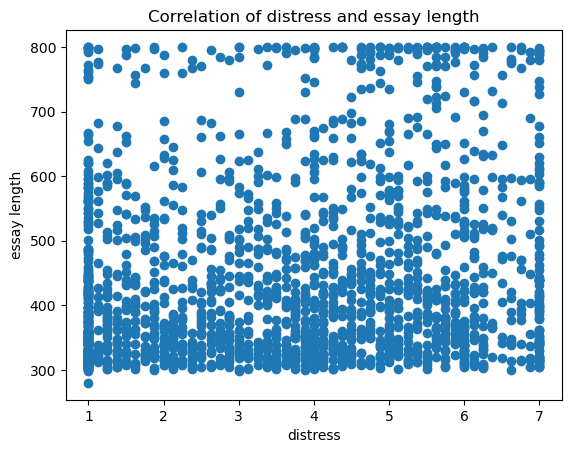

In [21]:
plt.scatter(joined.distress, joined.essay_len)
plt.title('Correlation of distress and essay length')
plt.xlabel('distress')
plt.ylabel('essay length')

### Correlate all variables

In [22]:
thresh = 0.1  # threshold to highlight correlations, set to 0 means looking at all data points
corr_table = joined.corr()
corr_table.where(np.abs(corr_table) >= thresh, '-')

,article_id,empathy,distress,empathy_bin,distress_bin,gender,education,race,age,income,...,personality_openess,personality_extraversion,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,article_len,essay_len
article_id,1.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-0.114835
empathy,-,1.0,0.450938,0.846136,0.378659,-,-,-,-,-,...,0.113773,0.209026,0.243257,0.103789,0.228567,-,0.161712,0.299363,-,0.14146
distress,-,0.450938,1.0,0.382185,0.860048,-,-,-,-,-,...,-,0.124056,0.12659,-,0.126524,0.189525,0.120541,0.198645,-,0.167784
empathy_bin,-,0.846136,0.382185,1.0,0.362133,-,-,-,-,-,...,-,0.170608,0.189598,-,0.203973,-,0.131431,0.235817,-,0.107289
distress_bin,-,0.378659,0.860048,0.362133,1.0,-,-,-,-,-,...,-,-,-,-,-,0.155334,-,0.130349,-,0.175385
gender,-,-,-,-,-,1.0,-,-,-,-,...,-,-,0.197429,-0.127292,0.120141,-,0.127233,0.178487,-,-
education,-,-,-,-,-,-,1.0,-,-,-,...,-,-,-,-,-,-0.104121,-,-0.102738,-,-
race,-,-,-,-,-,-,-,1.0,-0.199783,0.11291,...,-,-,-0.113082,-,-,-,-,-,-,-
age,-,-,-,-,-,-,-,-0.199783,1.0,-,...,-,-,0.146206,0.124038,-,-0.19048,-,-,-,0.157201
income,-,-,-,-,-,-,-,0.11291,-,1.0,...,-,-,-,-,-,-,-,-,-,-


## Desciptives for Data

In [24]:
print('Training data shape:', data_train.shape[0])
print('Dev data shape:', data_dev.shape[0])

Training data shape: 1860
Dev data shape: 270


### Empathy and distress boxplot

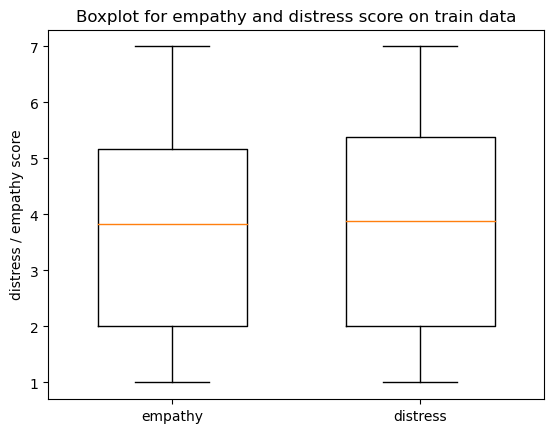

In [48]:
plt.boxplot(data_train[['empathy', 'distress']], widths=0.6, labels=['empathy', 'distress'])
plt.title('Boxplot for empathy and distress score on train data')
plt.ylabel('distress / empathy score')
plt.show()

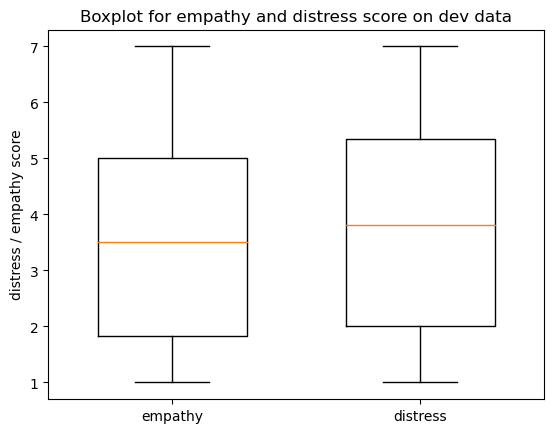

In [33]:
plt.boxplot(data_dev[['empathy', 'distress']], widths=0.6, labels=['empathy', 'distress'])
plt.title('Boxplot for empathy and distress score on dev data')
plt.ylabel('distress / empathy score')
plt.show()

In [38]:
# difference of mean on train and dev data
data_train[['empathy', 'distress']].mean() - data_dev[['empathy', 'distress']].mean()

empathy     0.141875
distress   -0.041570
dtype: float64

In [39]:
# difference of median on train and dev data
data_train[['empathy', 'distress']].median() - data_dev[['empathy', 'distress']].median()

empathy     0.3330
distress    0.0625
dtype: float64

In [43]:
# difference of mean of empathy and distress in train data
data_train[['empathy']].mean().item() - data_train[['distress']].mean().item()

-0.031200000000000117

In [44]:
# difference of mean of empathy and distress in train data
data_dev[['empathy']].mean().item() - data_dev[['distress']].mean().item()

-0.2146444444444442

### Mean

In [25]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).mean()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_18735/4117380871.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).mean()


empathy                              3.699916
distress                             3.731116
empathy_bin                          0.492473
distress_bin                         0.486559
age                                 35.317204
income                           57874.973118
personality_conscientiousness        5.555108
personality_openess                  5.201613
personality_extraversion             3.819892
personality_agreeableness            5.352151
personality_stability                4.950269
iri_perspective_taking               3.781879
iri_personal_distress                2.584892
iri_fantasy                          3.504594
iri_empathatic_concern               3.772634
dtype: float64

### Standard deviation

In [26]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).std()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_18735/2116255607.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).std()


empathy                              1.825406
distress                             1.891517
empathy_bin                          0.500078
distress_bin                         0.499954
age                                 10.130744
income                           64680.056724
personality_conscientiousness        1.314176
personality_openess                  1.352760
personality_extraversion             1.875590
personality_agreeableness            1.375424
personality_stability                1.622139
iri_perspective_taking               0.786226
iri_personal_distress                0.934901
iri_fantasy                          0.841145
iri_empathatic_concern               0.927051
dtype: float64

### Median

In [27]:
data_train.drop(columns=['article_id', 'gender','education', 'race']).median()

/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_18735/778282504.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_train.drop(columns=['article_id', 'gender','education', 'race']).median()


empathy                              3.833
distress                             3.875
empathy_bin                          0.000
distress_bin                         0.000
age                                 33.000
income                           50000.000
personality_conscientiousness        6.000
personality_openess                  5.500
personality_extraversion             4.000
personality_agreeableness            5.500
personality_stability                5.500
iri_perspective_taking               3.857
iri_personal_distress                2.571
iri_fantasy                          3.571
iri_empathatic_concern               3.857
dtype: float64

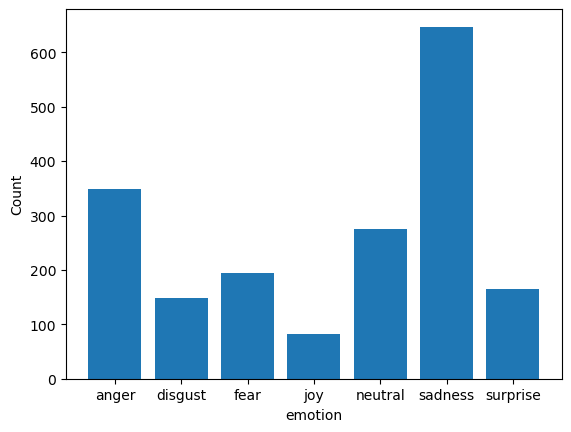

In [28]:
emotion_count = data_train.groupby('emotion').size()
emotion_labels = emotion_count.index.to_list()
plt.bar(range(len(emotion_count)), emotion_count)
plt.xticks(range(len(emotion_labels)), emotion_labels)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.show()


In [17]:
data_train.groupby('emotion').mean()[['empathy', 'distress', 'empathy_bin', 'distress_bin']]

,empathy,distress,empathy_bin,distress_bin
emotion,,,,
anger,3.053971,3.646132,0.346705,0.461318
disgust,3.363530,4.077181,0.409396,0.563758
fear,3.480253,3.802191,0.422680,0.489691
joy,4.044683,2.987805,0.573171,0.317073
neutral,3.638796,3.481364,0.498182,0.447273
sadness,4.280535,4.018547,0.627512,0.545595
surprise,3.279470,3.169970,0.378049,0.384146


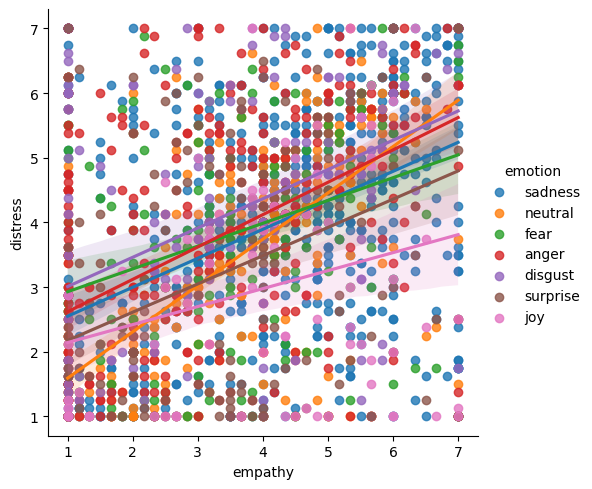

In [22]:
# the plot looks a little bit too messy, but we see difference in joy (joy is also under represented)
sns.lmplot(x="empathy", y="distress", data=data_train, hue="emotion")

## Distribution of empathy answers

In [18]:
person_emp_dis_means = data_train[['empathy', 'distress', 'response_id']].groupby('response_id').mean()
person_emp_dis_means[:5]

,empathy,distress
response_id,,
R_03ql4LGD9I0cM7f,4.9334,4.325
R_088bdUkTs4jYl7b,3.2000,3.500
R_0CE9rf8V9zj643T,3.3664,3.300
R_0OePPQQ0Eu8vF3X,3.8000,5.800
R_0e3M54QcgpFMC3v,2.8334,3.025



 mean distress and mean empathy 
 r: 0.5851 
 p: 0.00000000


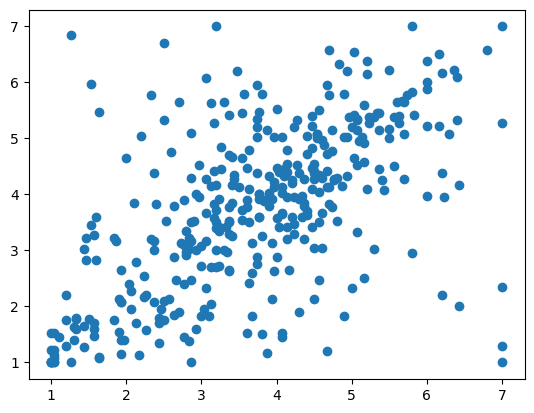

In [19]:
plt.scatter(person_emp_dis_means.empathy, person_emp_dis_means.distress)
r, p = pearsonr(person_emp_dis_means['empathy'], person_emp_dis_means['distress'])

print('\n mean distress and mean empathy \n r: {:.4f} \n p: {:.8f}'.format(r, p))

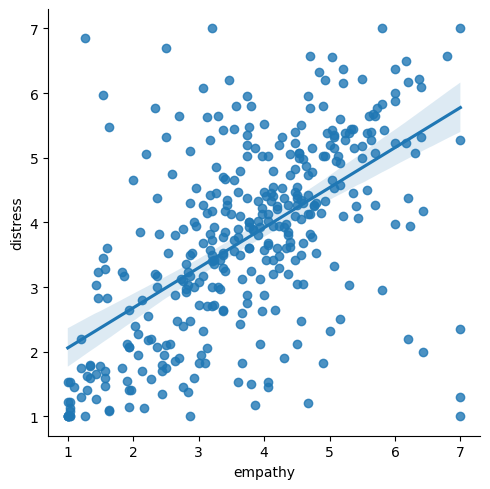

In [29]:
# source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html
ax = sns.lmplot(x="empathy", y="distress", data=person_emp_dis_means)